In [1]:
import torch
from torch import nn
import numpy as np
import pandas as pd
import os
import sys
import time
import cv2
from PIL import Image
from collections import defaultdict
from datetime import datetime
from torchvision import transforms

import matplotlib.pyplot as plt

from torch.distributions.multivariate_normal import MultivariateNormal
from torch.utils.data import DataLoader, Dataset


# Path initialization
# CUR_DIR=os.path.dirname(os.path.dirname(os.path.abspath(__file__)))

sys.path.insert(0, "../vae_architectures")
from VAE import VAE1
from CondVAE import CondVAE

/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [ ]:
df_attr = pd.read_csv("../../data/Anno/df_attr.csv")

## Data

In [2]:
df_attr = pd.read_csv("../../data/Anno/df_attr.csv")

In [3]:
# Train and val imgs
df_split = pd.read_csv("../../data/Eval/train_val_test_split.csv")
imgs_train = df_split[df_split.phase == "train"].img_names.values[0]
imgs_train = [name for name in imgs_train.split("'") if ".jpg" in name]
imgs_val = df_split[df_split.phase == "val"].img_names.values[0]
imgs_val = [name for name in imgs_val.split("'") if ".jpg" in name]

In [4]:
VALID_PARTITIONS = {'train': 0, 'val': 1, 'test': 2}
# go from label index to interpretable index
ATTR_TO_IX_DICT  = {'Sideburns': 30, 'Black_Hair': 8, 'Wavy_Hair': 33, 'Young': 39, 'Heavy_Makeup': 18, 
                    'Blond_Hair': 9, 'Attractive': 2, '5_o_Clock_Shadow': 0, 'Wearing_Necktie': 38, 
                    'Blurry': 10, 'Double_Chin': 14, 'Brown_Hair': 11, 'Mouth_Slightly_Open': 21, 
                    'Goatee': 16, 'Bald': 4, 'Pointy_Nose': 27, 'Gray_Hair': 17, 'Pale_Skin': 26, 
                    'Arched_Eyebrows': 1, 'Wearing_Hat': 35, 'Receding_Hairline': 28, 'Straight_Hair': 32, 
                    'Big_Nose': 7, 'Rosy_Cheeks': 29, 'Oval_Face': 25, 'Bangs': 5, 'Male': 20, 'Mustache': 22, 
                    'High_Cheekbones': 19, 'No_Beard': 24, 'Eyeglasses': 15, 'Bags_Under_Eyes': 3, 
                    'Wearing_Necklace': 37, 'Wearing_Lipstick': 36, 'Big_Lips': 6, 'Narrow_Eyes': 23, 
                    'Chubby': 13, 'Smiling': 31, 'Bushy_Eyebrows': 12, 'Wearing_Earrings': 34}
# we only keep 18 of the more visually distinctive features
# See [1] Perarnau, Guim, et al. "Invertible conditional gans for 
#         image editing." arXiv preprint arXiv:1611.06355 (2016).
ATTR_IX_TO_KEEP  = [4, 5, 8, 9, 11, 12, 15, 17, 18, 20, 21, 22, 26, 28, 31, 32, 33, 35]
IX_TO_ATTR_DICT  = {v:k for k, v in ATTR_TO_IX_DICT.items()}
N_ATTRS          = len(ATTR_IX_TO_KEEP)
ATTR_TO_PLOT     = ['Heavy_Makeup', 'Male', 'Mouth_Slightly_Open', 'Smiling', 'Wavy_Hair']

In [5]:
def get_attr(img_name):
    df_attr_img = df_attr[df_attr.img_name == img_name]
    attr = df_attr_img.values[0, 1:]
    attr   = np.array(attr).astype(int)
    attr[attr < 0] = 0
    attr = torch.from_numpy(attr).float()
    return attr[ATTR_IX_TO_KEEP]
    

In [6]:
def tensor_to_attributes(tensor):
    """Use this for the <image_transform>.
    @param tensor: PyTorch Tensor
                   D dimensional tensor
    @return attributes: list of strings
    """
    attrs  = []
    n      = tensor.size(0)
    tensor = torch.round(tensor)
    
    for i in range(n):
        if tensor[i] > 0.5:
            attr = IX_TO_ATTR_DICT[ATTR_IX_TO_KEEP[i]]
            attrs.append(attr)
    return attrs



In [7]:
ROOT = "../../img_align_celeba"

class FaceData_with_Attributes(Dataset):
    def __init__(self, img_names, image_transform=None, attr_transform=None):

        self.img_names = img_names
        
        self.size = int(len(img_names))

        self.image_transform = image_transform
        self.attr_transform  = attr_transform

    def __len__(self):
        return len(self.img_name)

    def __getitem__(self, index):

        # attr
        attr = get_attr(self.img_names[index])

        if self.attr_transform is not None:
            attr = self.attr_transform(attr)

        # img 
        img_path = os.path.join(ROOT, self.img_names[index])

        img = Image.open(img_path)
        img = img.resize((256, 256), Image.ANTIALIAS)
        img = img.crop((32, 32, 224, 224))
        img = img.resize((64, 64), Image.ANTIALIAS)
        if self.image_transform is not None:
            img  = self.image_transform(img)
            
        img = np.array(img)

#         return img.transpose(2, 0, 1) / 255., attr
        return img, attr
    
    def __len__(self):
        return self.size

In [8]:
preprocess_data = transforms.Compose([transforms.Resize(64),
                                          transforms.CenterCrop(64),
                                          transforms.ToTensor()])

In [9]:
img_names = {"train": imgs_train, "val": imgs_val}
# datasets = {phase: FaceData_with_Attributes(img_names[phase], image_transform=preprocess_data) 
#             for phase in ["train", "val"]}
datasets = {phase: FaceData_with_Attributes(df_attr.img_name.values[:10000], image_transform=preprocess_data) 
            for phase in ["train", "val"]}
dataloaders = {phase: DataLoader(datasets[phase], batch_size=8, shuffle=True, num_workers=2) 
               for phase in ["train", "val"]}

['Male', 'Mouth_Slightly_Open', 'Smiling']


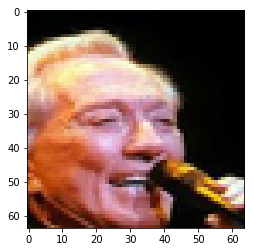

In [10]:
for x, y in dataloaders["val"]:
    plt.imshow(x[0].numpy().transpose(1, 2, 0))
    print(tensor_to_attributes(y[0]))

    break

## Model

In [11]:
import torch
from torch import nn
import numpy as np
import pandas as pd
import os
import sys
import time
import cv2
from PIL import Image
from collections import defaultdict
from datetime import datetime
from torchvision import transforms
import torch.optim as optim

import matplotlib.pyplot as plt

from torch.distributions.multivariate_normal import MultivariateNormal
from torch.utils.data import DataLoader, Dataset

import torch.nn.functional as F
from torch.autograd import Variable


# Path initialization
# CUR_DIR=os.path.dirname(os.path.dirname(os.path.abspath(__file__)))

sys.path.insert(0, "../vae_architectures")
from VAE import VAE1
from CondVAE import CondVAE

In [59]:
def elbo_loss(recon_image, image, recon_attrs, attrs, mu, logvar,
                  lambda_image=1.0, lambda_attrs=1.0, annealing_factor=1):
    
    image_mse, attrs_bce = 0, 0 
    
    if recon_image is not None and image is not None:
        image_mse = ((torch.sigmoid(recon_image) - image)**2).mean(dim=(1,2,3))

    if recon_attrs is not None and attrs is not None:
        for i in range(N_ATTRS):
            attr_bce = binary_cross_entropy_with_logits(
                recon_attrs[:, i], attrs[:, i])
            attrs_bce += attr_bce

    # Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014
    # https://arxiv.org/abs/1312.6114
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp(), dim=1)
    ELBO = torch.mean(lambda_image * image_mse + lambda_attrs * attrs_bce 
                      + annealing_factor * KLD)
    try:
        print("DDD", image_mse.mean(), attrs_bce.mean(), KLD.mean())
    except:
        print("DDD", image_mse, attrs_bce, KLD.mean())

    return ELBO

In [60]:
# def elbo_loss(recon_image, image, recon_attrs, attrs, mu, logvar,
#               lambda_image=1.0, lambda_attrs=1.0, annealing_factor=1):
    
#     image_bce, attrs_bce = 0, 0  # default params
    
#     if recon_image is not None and image is not None:
#         image_bce = torch.sum(binary_cross_entropy_with_logits(
#             recon_image.view(-1, 3 * 64 * 64), 
#             image.view(-1, 3 * 64 * 64)), dim=1)

#     if recon_attrs is not None and attrs is not None:
#         for i in range(N_ATTRS):
#             attr_bce = binary_cross_entropy_with_logits(
#                 recon_attrs[:, i], attrs[:, i])
#             attrs_bce += attr_bce

#     # Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014
#     # https://arxiv.org/abs/1312.6114
#     KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp(), dim=1)
#     ELBO = torch.mean(lambda_image * image_bce + lambda_attrs * attrs_bce 
#                       + annealing_factor * KLD)
#     try:
#         print(image_bce.mean(), attrs_bce.mean(), KLD.mean())
#     except:
#         print(image_bce, attrs_bce, KLD.mean())
#     return ELBO


def binary_cross_entropy_with_logits(input, target):
    
    if not (target.size() == input.size()):
        raise ValueError("Target size ({}) must be the same as input size ({})".format(
            target.size(), input.size()))

    return (torch.clamp(input, 0) - input * target + torch.log(1 + torch.exp(-torch.abs(input))))

In [61]:
model = CondVAE(128, 32, 0.04, N_ATTRS)
optimizer = optim.Adam(model.parameters(), lr=1e-4)

model.train()

CondVAE(
  (VAE): VAE1(
    (encoder): Sequential(
      (block01): Conv_block(
        (conv): Conv2d(3, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
        (activation): LeakyReLU(negative_slope=0.2)
        (dropout): Dropout2d(p=0.04)
        (batch_norm): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (block02): Conv_block(
        (conv): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
        (activation): LeakyReLU(negative_slope=0.2)
        (dropout): Dropout2d(p=0.04)
        (batch_norm): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (block03): Conv_block(
        (conv): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
        (activation): LeakyReLU(negative_slope=0.2)
        (dropout): Dropout2d(p=0.04)
        (batch_norm): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (block04): C

/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1332: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


DDD tensor(0.1145, grad_fn=<MeanBackward1>) tensor(12.5117, grad_fn=<MeanBackward1>) tensor(31.7626, grad_fn=<MeanBackward1>)
DDD tensor([0.0926, 0.1051, 0.1286, 0.1438, 0.1414, 0.0837, 0.1148, 0.1027],
       grad_fn=<MeanBackward0>) 0 tensor(18.2637, grad_fn=<MeanBackward1>)
DDD 0 tensor([13.0796, 11.9666, 13.1297, 13.0614, 11.9391, 12.1018, 12.8672, 12.2170],
       grad_fn=<AddBackward0>) tensor(13.1643, grad_fn=<MeanBackward1>)
0itr: 0.20879732072353363 + 0.13236062228679657 + 0.13861721754074097 = 0.47977516055107117


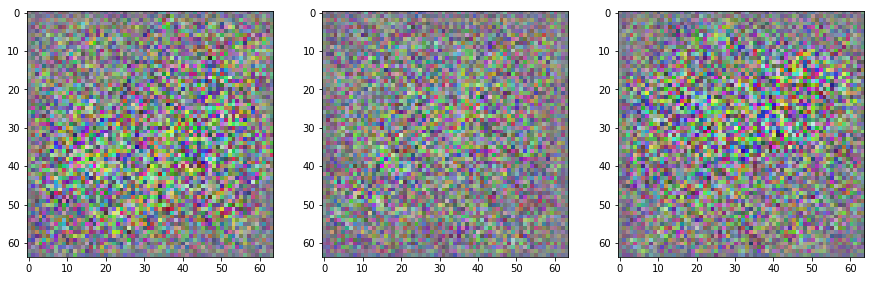

DDD tensor(0.1082, grad_fn=<MeanBackward1>) tensor(12.5420, grad_fn=<MeanBackward1>) tensor(31.4120, grad_fn=<MeanBackward1>)
DDD tensor([0.0713, 0.1742, 0.1004, 0.1450, 0.1015, 0.0714, 0.1242, 0.0861],
       grad_fn=<MeanBackward0>) 0 tensor(18.3978, grad_fn=<MeanBackward1>)
DDD 0 tensor([12.5544, 12.3972, 13.0344, 12.3987, 12.6428, 13.2820, 13.3009, 12.0658],
       grad_fn=<AddBackward0>) tensor(13.1033, grad_fn=<MeanBackward1>)
1itr: 0.20227281749248505 + 0.12765468657016754 + 0.14019857347011566 = 0.47012609243392944
DDD tensor(0.0989, grad_fn=<MeanBackward1>) tensor(12.6434, grad_fn=<MeanBackward1>) tensor(31.3146, grad_fn=<MeanBackward1>)
DDD tensor([0.0617, 0.0986, 0.1217, 0.0885, 0.1335, 0.0914, 0.1267, 0.0753],
       grad_fn=<MeanBackward0>) 0 tensor(18.9476, grad_fn=<MeanBackward1>)
DDD 0 tensor([12.1665, 12.5419, 12.4688, 12.2303, 12.7052, 12.6257, 12.7068, 12.9178],
       grad_fn=<AddBackward0>) tensor(13.0721, grad_fn=<MeanBackward1>)
2itr: 0.19339127838611603 + 0.1186

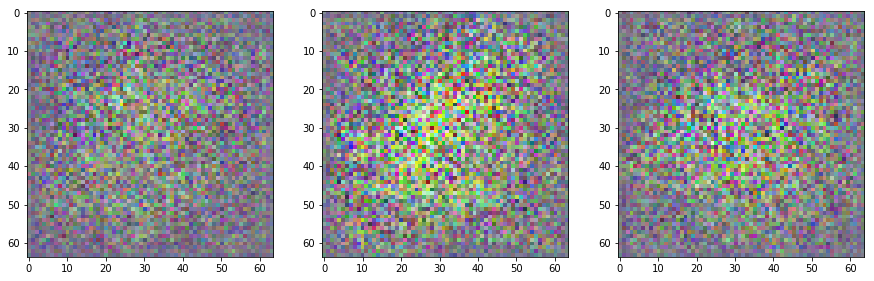

DDD tensor(0.1069, grad_fn=<MeanBackward1>) tensor(12.4710, grad_fn=<MeanBackward1>) tensor(29.7378, grad_fn=<MeanBackward1>)
DDD tensor([0.1076, 0.1003, 0.1514, 0.0902, 0.0879, 0.0823, 0.0828, 0.1527],
       grad_fn=<MeanBackward0>) 0 tensor(16.8759, grad_fn=<MeanBackward1>)
DDD 0 tensor([11.9567, 12.6019, 12.9374, 12.4278, 12.3071, 12.0604, 12.0573, 12.0017],
       grad_fn=<AddBackward0>) tensor(12.5795, grad_fn=<MeanBackward1>)
11itr: 0.199042409658432 + 0.12377112358808517 + 0.13551734387874603 = 0.4583308696746826
DDD tensor(0.1051, grad_fn=<MeanBackward1>) tensor(12.3585, grad_fn=<MeanBackward1>) tensor(29.6450, grad_fn=<MeanBackward1>)
DDD tensor([0.0743, 0.1177, 0.1000, 0.0867, 0.0838, 0.1305, 0.1182, 0.1306],
       grad_fn=<MeanBackward0>) 0 tensor(16.9151, grad_fn=<MeanBackward1>)
DDD 0 tensor([12.0930, 12.4547, 11.4629, 12.5698, 12.0462, 12.1814, 11.3897, 12.6135],
       grad_fn=<AddBackward0>) tensor(12.4413, grad_fn=<MeanBackward1>)
12itr: 0.19651596248149872 + 0.12213

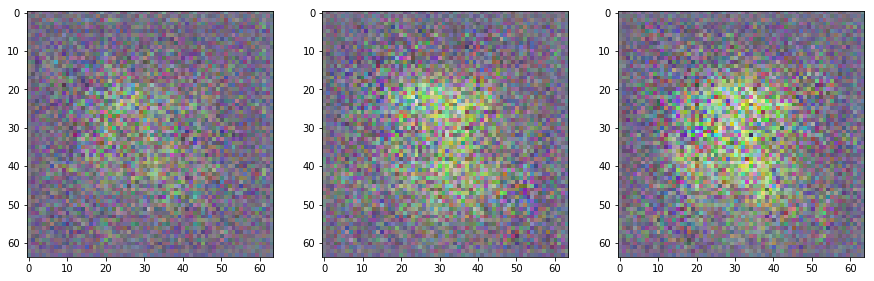

DDD tensor(0.0946, grad_fn=<MeanBackward1>) tensor(11.8091, grad_fn=<MeanBackward1>) tensor(27.9868, grad_fn=<MeanBackward1>)
DDD tensor([0.1085, 0.0622, 0.1119, 0.0707, 0.0848, 0.1387, 0.0764, 0.0779],
       grad_fn=<MeanBackward0>) 0 tensor(15.0977, grad_fn=<MeanBackward1>)
DDD 0 tensor([12.2230, 11.5629, 11.4325, 12.0925, 11.7493, 12.3838, 11.8234, 11.3978],
       grad_fn=<AddBackward0>) tensor(11.8852, grad_fn=<MeanBackward1>)
21itr: 0.1816164255142212 + 0.10647164285182953 + 0.13021665811538696 = 0.4183047413825989
DDD tensor(0.0873, grad_fn=<MeanBackward1>) tensor(11.9524, grad_fn=<MeanBackward1>) tensor(27.5804, grad_fn=<MeanBackward1>)
DDD tensor([0.0880, 0.0599, 0.1203, 0.0734, 0.0907, 0.0668, 0.0922, 0.1098],
       grad_fn=<MeanBackward0>) 0 tensor(14.9335, grad_fn=<MeanBackward1>)
DDD 0 tensor([11.9365, 11.8511, 12.3693, 12.4567, 11.8321, 12.2622, 11.1993, 11.8141],
       grad_fn=<AddBackward0>) tensor(11.8236, grad_fn=<MeanBackward1>)
22itr: 0.1746378093957901 + 0.10258

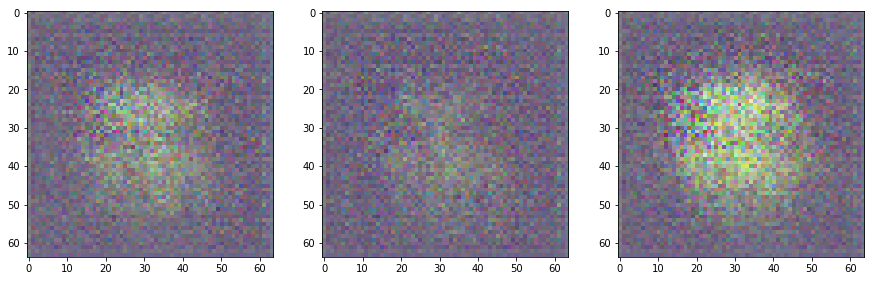

DDD tensor(0.0938, grad_fn=<MeanBackward1>) tensor(11.5120, grad_fn=<MeanBackward1>) tensor(26.6087, grad_fn=<MeanBackward1>)
DDD tensor([0.1137, 0.0626, 0.0576, 0.1300, 0.0972, 0.1093, 0.0725, 0.1160],
       grad_fn=<MeanBackward0>) 0 tensor(14.1076, grad_fn=<MeanBackward1>)
DDD 0 tensor([11.9494, 12.2046, 12.0852, 11.1982, 12.3338, 11.0049, 11.6649, 12.0153],
       grad_fn=<AddBackward0>) tensor(11.5060, grad_fn=<MeanBackward1>)
31itr: 0.17798572778701782 + 0.10895150899887085 + 0.12957629561424255 = 0.4165135324001312
DDD tensor(0.0791, grad_fn=<MeanBackward1>) tensor(12.1748, grad_fn=<MeanBackward1>) tensor(26.1553, grad_fn=<MeanBackward1>)
DDD tensor([0.0845, 0.0658, 0.0703, 0.0845, 0.0554, 0.0740, 0.1439, 0.0491],
       grad_fn=<MeanBackward0>) 0 tensor(14.4029, grad_fn=<MeanBackward1>)
DDD 0 tensor([12.1778, 10.6583, 11.1509, 11.9339, 11.7734, 11.2704, 11.1326, 11.7723],
       grad_fn=<AddBackward0>) tensor(11.3148, grad_fn=<MeanBackward1>)
32itr: 0.1661367416381836 + 0.0928

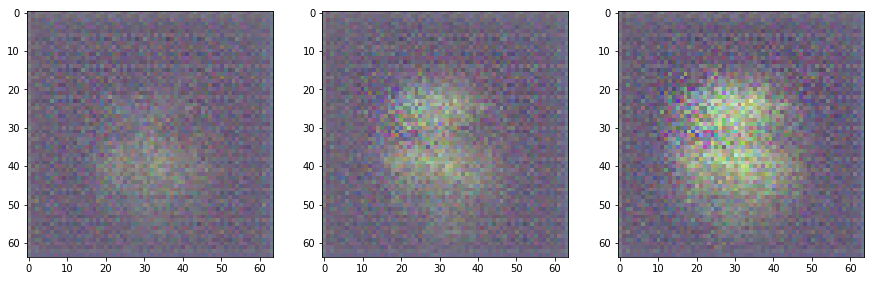

DDD tensor(0.0799, grad_fn=<MeanBackward1>) tensor(11.3494, grad_fn=<MeanBackward1>) tensor(24.5680, grad_fn=<MeanBackward1>)
DDD tensor([0.0628, 0.0831, 0.0988, 0.0941, 0.0704, 0.1164, 0.0342, 0.0674],
       grad_fn=<MeanBackward0>) 0 tensor(12.6674, grad_fn=<MeanBackward1>)
DDD 0 tensor([10.2074, 11.0024, 10.2195, 11.0651, 10.4445, 10.5694, 10.9411, 10.1074],
       grad_fn=<AddBackward0>) tensor(11.1895, grad_fn=<MeanBackward1>)
41itr: 0.1612512171268463 + 0.0910613015294075 + 0.11688542366027832 = 0.36919793486595154
DDD tensor(0.0834, grad_fn=<MeanBackward1>) tensor(11.2304, grad_fn=<MeanBackward1>) tensor(24.5547, grad_fn=<MeanBackward1>)
DDD tensor([0.0383, 0.1010, 0.1126, 0.1332, 0.0770, 0.0544, 0.0605, 0.1061],
       grad_fn=<MeanBackward0>) 0 tensor(12.8258, grad_fn=<MeanBackward1>)
DDD 0 tensor([10.0306, 11.0647, 10.3934, 10.3191, 10.9895, 11.2113, 11.4512, 10.0693],
       grad_fn=<AddBackward0>) tensor(10.9248, grad_fn=<MeanBackward1>)
42itr: 0.16411985456943512 + 0.0982

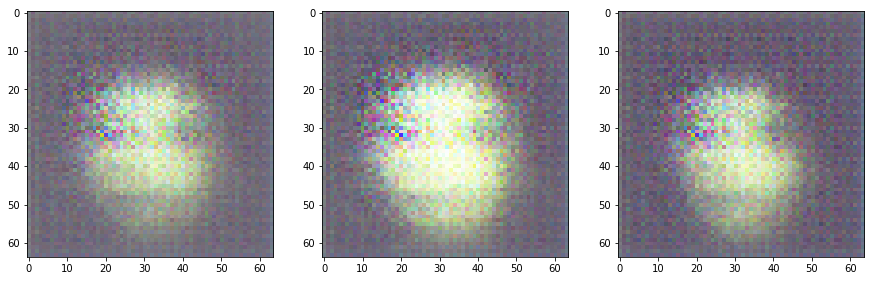

DDD tensor(0.0795, grad_fn=<MeanBackward1>) tensor(10.8302, grad_fn=<MeanBackward1>) tensor(22.5379, grad_fn=<MeanBackward1>)
DDD tensor([0.1147, 0.0647, 0.0558, 0.0574, 0.0867, 0.0776, 0.0721, 0.1070],
       grad_fn=<MeanBackward0>) 0 tensor(10.8183, grad_fn=<MeanBackward1>)
DDD 0 tensor([10.4784,  8.8751, 11.0543, 10.3170, 10.7259, 11.3109, 11.1292,  9.8646],
       grad_fn=<AddBackward0>) tensor(10.6577, grad_fn=<MeanBackward1>)
51itr: 0.15621815621852875 + 0.09031549841165543 + 0.11535198241472244 = 0.3618856370449066
DDD tensor(0.0874, grad_fn=<MeanBackward1>) tensor(10.4866, grad_fn=<MeanBackward1>) tensor(22.2564, grad_fn=<MeanBackward1>)
DDD tensor([0.0984, 0.0671, 0.0610, 0.0938, 0.1725, 0.1113, 0.0487, 0.0619],
       grad_fn=<MeanBackward0>) 0 tensor(10.6361, grad_fn=<MeanBackward1>)
DDD 0 tensor([ 8.8149, 10.9449, 11.2121, 11.7795, 11.4536, 10.8265,  9.2039, 11.6702],
       grad_fn=<AddBackward0>) tensor(10.3959, grad_fn=<MeanBackward1>)
52itr: 0.16210468113422394 + 0.099

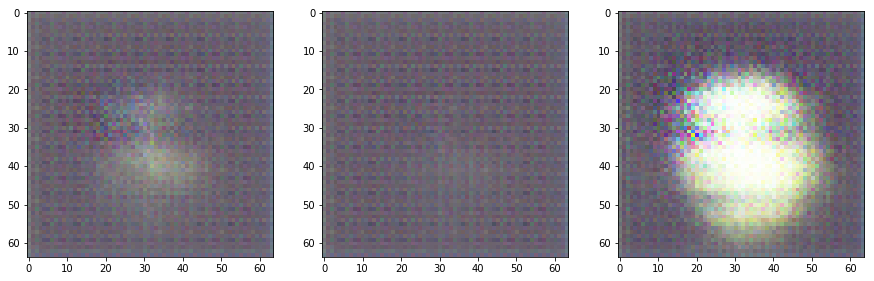

DDD tensor(0.0912, grad_fn=<MeanBackward1>) tensor(10.2595, grad_fn=<MeanBackward1>) tensor(20.2758, grad_fn=<MeanBackward1>)
DDD tensor([0.1395, 0.0536, 0.0742, 0.0905, 0.1010, 0.0852, 0.0762, 0.0869],
       grad_fn=<MeanBackward0>) 0 tensor(8.8907, grad_fn=<MeanBackward1>)
DDD 0 tensor([ 8.7190, 10.1409,  8.9931,  8.9004,  8.9476,  9.3635,  9.6569, 10.6924],
       grad_fn=<AddBackward0>) tensor(10.3803, grad_fn=<MeanBackward1>)
61itr: 0.1628229171037674 + 0.09727688133716583 + 0.10464746505022049 = 0.3647472560405731
DDD tensor(0.0848, grad_fn=<MeanBackward1>) tensor(10.0636, grad_fn=<MeanBackward1>) tensor(20.0991, grad_fn=<MeanBackward1>)
DDD tensor([0.0666, 0.0640, 0.0842, 0.0740, 0.0647, 0.1227, 0.0911, 0.0867],
       grad_fn=<MeanBackward0>) 0 tensor(8.7503, grad_fn=<MeanBackward1>)
DDD 0 tensor([11.6195, 10.6063,  8.5354, 11.5944,  9.9203,  7.6911,  9.4400, 11.0147],
       grad_fn=<AddBackward0>) tensor(10.1418, grad_fn=<MeanBackward1>)
62itr: 0.15525254607200623 + 0.090495

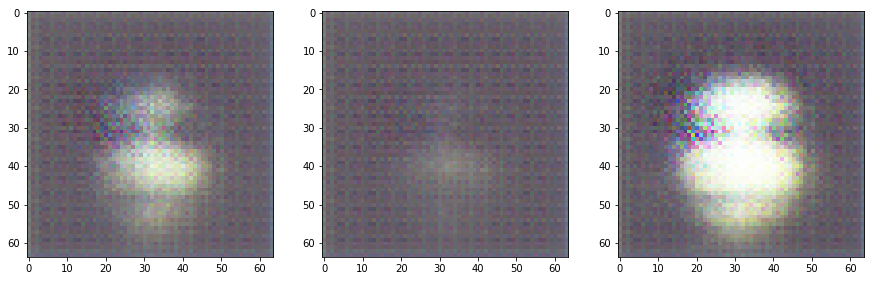

DDD tensor(0.0796, grad_fn=<MeanBackward1>) tensor(9.3559, grad_fn=<MeanBackward1>) tensor(18.0143, grad_fn=<MeanBackward1>)
DDD tensor([0.0616, 0.0715, 0.0918, 0.0761, 0.1069, 0.0808, 0.0891, 0.0642],
       grad_fn=<MeanBackward0>) 0 tensor(6.7927, grad_fn=<MeanBackward1>)
DDD 0 tensor([ 8.5641,  9.9692,  9.8844,  9.8320, 11.0894,  9.2671,  9.1134, 10.4276],
       grad_fn=<AddBackward0>) tensor(10.1324, grad_fn=<MeanBackward1>)
71itr: 0.14439713954925537 + 0.08705025166273117 + 0.10781650990247726 = 0.339263916015625
DDD tensor(0.0792, grad_fn=<MeanBackward1>) tensor(9.9007, grad_fn=<MeanBackward1>) tensor(17.7276, grad_fn=<MeanBackward1>)
DDD tensor([0.0879, 0.0540, 0.0704, 0.0755, 0.1005, 0.0597, 0.1231, 0.0652],
       grad_fn=<MeanBackward0>) 0 tensor(6.5486, grad_fn=<MeanBackward1>)
DDD 0 tensor([ 9.5487,  9.6504,  8.0232,  8.7300, 10.5241,  8.9819,  9.2151, 10.9482],
       grad_fn=<AddBackward0>) tensor(10.2123, grad_fn=<MeanBackward1>)
72itr: 0.14646834135055542 + 0.08607507

KeyboardInterrupt: 

In [63]:
for ii, (image, attrs) in enumerate(dataloaders["train"]):

    image      = Variable(image)
    attrs      = Variable(attrs)
    batch_size = len(image)


    # pass data through model
    recon_image_1, recon_attrs_1, mu_1, logvar_1 = model(image, attrs)
    recon_image_2, recon_attrs_2, mu_2, logvar_2 = model(image)
    recon_image_3, recon_attrs_3, mu_3, logvar_3 = model(attrs=attrs)
    
    # compute ELBO for each data combo
    joint_loss = elbo_loss(recon_image_1, image, recon_attrs_1, attrs, mu_1, logvar_1, 
                           lambda_image=1., lambda_attrs=0.005,
                           annealing_factor=0.001)
    
    image_loss = elbo_loss(recon_image_2, image, None, None, mu_2, logvar_2, 
                           lambda_image=1.,  lambda_attrs=0.005,
                           annealing_factor=0.001)
    
    attrs_loss = elbo_loss(None, None, recon_attrs_3, attrs, mu_3, logvar_3, 
                           lambda_image=1.,  lambda_attrs=0.01,
                           annealing_factor=0.001)
    
    train_loss = joint_loss + image_loss + attrs_loss
    
    train_loss.backward()
    optimizer.step()
    print("{}itr: {} + {} + {} = {}".format(ii, joint_loss, image_loss, attrs_loss, train_loss))
    
    if ii % 10 == 0:
        fig, ax = plt.subplots(1, 3, figsize=(15, 5))

        ax[0].imshow(torch.sigmoid(recon_image_1[0]).detach().numpy().transpose(1, 2, 0))
        ax[1].imshow(torch.sigmoid(recon_image_2[0]).detach().numpy().transpose(1, 2, 0))
        ax[2].imshow(torch.sigmoid(recon_image_3[0]).detach().numpy().transpose(1, 2, 0))
        plt.show()
    
